In [1]:
import MDAnalysis as mda


def get_true_mda_universe(pdb_id, root_path):
    # Favor PDB since it doesn't have multiple residue with same ID issue
    if (root_path / (pdb_id + ".pdb")).exists():
        suffix = ".pdb"

    else:
        suffix = ".cif"

    return mda.Universe((root_path / (pdb_id + suffix)).as_posix())

/home/lwoods/miniconda3/envs/af3-analyzer/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import polars as pl
from pathlib import Path

struct_root = Path("../data/pdb/struct")
inf_root = Path("../data/pdb/inference")
pdb_triads = pl.read_parquet("../data/pdb/pdb_triads.parquet")

BROKEN_PDBS = ["1bd2", "3kpr", "3pwp"]

In [7]:
pdb_id = pdb_triads[0].select("pdb").item()

u = get_true_mda_universe(pdb_id, struct_root)

2. from both files, remove anything that isn't an alpha carbon (I think this is fairly standard in the field)
3. extract the amino acid sequences from those 2 files (note this from is the pdb / cif structure files, NOT from the fastas)
4. perform MSAs to align pred v PDB AA sequences (for each chain individually), and then take all positions where there is a matched AA in both sequences (this takes care of appendages like epitope tags, or gaps in the crystal structure)
5. perform procrustes alignment to account for different rotation / translation
6. perform RMSD calculations


In [3]:
from mdaf3.AF3OutputParser import *
from mdaf3.FeatureExtraction import *
from MDAnalysis.analysis.align import alignto
import Bio.Align
from MDAnalysis.analysis.rms import rmsd

aligner = Bio.Align.PairwiseAligner(mode="global")


def true_pred_rmsd(row, true_path, pred_path, aligner):
    af3_output = AF3Output(pred_path / row["job_name"])

    pred_u = af3_output.get_mda_universe()
    true_u = get_true_mda_universe(row["pdb"], true_path)

    # list of 5, where each element is the portion of the chain
    # that aligns from pred -> true
    true_chainsels = []
    pred_chainsels = []

    for pred_segid, true_segid in zip(
        ["A", "B", "C", "D", "E"],
        [
            row["antigen_chain"],
            row["mhc_chain1"],
            row["mhc_chain2"],
            row["Achain"],
            row["Bchain"],
        ],
    ):

        # remove HOH, etc with record_type
        pred_residues = pred_u.select_atoms(
            f"segid {pred_segid} and name CA"
        ).residues
        # https://github.com/MDAnalysis/mdanalysis/issues/2868#issuecomment-663785174
        # when altloc present, choose first
        # else select empty string as altloc
        true_residues = true_u.select_atoms(
            f"segid {true_segid} and name CA and (altloc A or not altloc [!?])"
        ).residues

        try:
            true_seq = true_residues.sequence(format="Seq")
        except ValueError:
            # sometimes fasta contains all valid AAs, but seq contains
            # non-standard residues
            new_row = row.copy()
            new_row["rmsd_triad"] = None
            new_row["rmsd_tcr"] = None
            new_row["rmsd_pmhc"] = None
            return pl.DataFrame(new_row)
        pred_seq = pred_residues.sequence(format="Seq")

        # Alignment[0] is best alignment
        seq_aln = aligner.align(
            true_seq,
            pred_seq,
        )[0]

        true_aln = seq_aln[0]
        pred_aln = seq_aln[1]

        true_resindices = true_residues.resindices
        true_res_boolmask = np.full(
            true_resindices.shape, False, dtype=np.bool
        )
        pred_resindices = pred_residues.resindices
        pred_res_boolmask = np.full(
            pred_resindices.shape, False, dtype=np.bool
        )

        true_ptr = 0
        pred_ptr = 0
        for i in range(len(true_aln)):
            if true_aln[i] == "-":
                pred_ptr += 1
                continue
            elif pred_aln[i] == "-":
                true_ptr += 1
                continue

            else:
                true_res_boolmask[true_ptr] = True
                pred_res_boolmask[pred_ptr] = True
                true_ptr += 1
                pred_ptr += 1

        true_chainsels.append(
            # altloc eliminates uncertainty in position
            true_residues[true_res_boolmask].atoms.select_atoms(
                "name CA and (altloc A or not altloc [!?])"
            )
        )
        pred_chainsels.append(
            # altloc here should be noop
            pred_residues[pred_res_boolmask].atoms.select_atoms("name CA")
        )

    # quick check that we are selecting identical residues
    for i in range(5):
        assert true_chainsels[i].residues.sequence(
            format="string"
        ) == pred_chainsels[i].residues.sequence(format="string")

    tcr_true_calphas = sum(true_chainsels[3:5])
    tcr_pred_calphas = sum(pred_chainsels[3:5])

    rmsd_tcr = rmsd(
        tcr_true_calphas.positions,
        tcr_pred_calphas.positions,
        superposition=True,
    )

    pmhc_true_calphas = sum(true_chainsels[:3])
    pmhc_pred_calphas = sum(pred_chainsels[:3])

    rmsd_pmhc = rmsd(
        pmhc_true_calphas.positions,
        pmhc_pred_calphas.positions,
        superposition=True,
    )

    all_true_calphas = sum(true_chainsels)
    all_pred_calphas = sum(pred_chainsels)

    rmsd_triad = rmsd(
        all_true_calphas.positions,
        all_pred_calphas.positions,
        superposition=True,
    )

    new_row = row.copy()
    new_row["rmsd_triad"] = rmsd_triad
    new_row["rmsd_tcr"] = rmsd_tcr
    new_row["rmsd_pmhc"] = rmsd_pmhc

    return pl.DataFrame(new_row)


rmsd_df = serial_apply(
    pdb_triads,
    true_pred_rmsd,
    struct_root,
    inf_root,
    aligner,
)

/home/lwoods/miniconda3/envs/af3-analyzer/lib/python3.13/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
Processing rows:   0%|          | 0/246 [00:00<?, ?it/s]/home/lwoods/workspace/mdanalysis/package/MDAnalysis/coordinates/MMCIF.py:139: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn(
Processing rows:   9%|▉         | 23/246 [00:03<00:32,  6.84it/s]/home/lwoods/workspace/mdanalysis/package/MDAnalysis/coordinates/PDB.py:453: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None

In [10]:
rmsd_df.filter(pl.col("rmsd_triad").is_not_null()).write_csv("rmsd_pdb.csv")

In [6]:
rmsd_df.filter(pl.col("rmsd_triad").is_not_null()).select(
    "pdb", "rmsd_triad", "rmsd_tcr", "rmsd_pmhc"
)

pdb,rmsd_triad,rmsd_tcr,rmsd_pmhc
str,f64,f64,f64
"""8cx4""",1.408754,0.911162,1.156778
"""3vxs""",1.719954,0.646725,0.56289
"""5e9d""",1.170697,0.568597,0.672518
"""3kpr""",1.495064,0.76311,0.515873
"""1bd2""",1.771326,1.225497,0.755833
…,…,…,…
"""1d9k""",1.394155,1.108084,0.877915
"""3qiu""",1.136663,0.752404,0.741522
"""3mbe""",0.879262,0.857346,0.798165


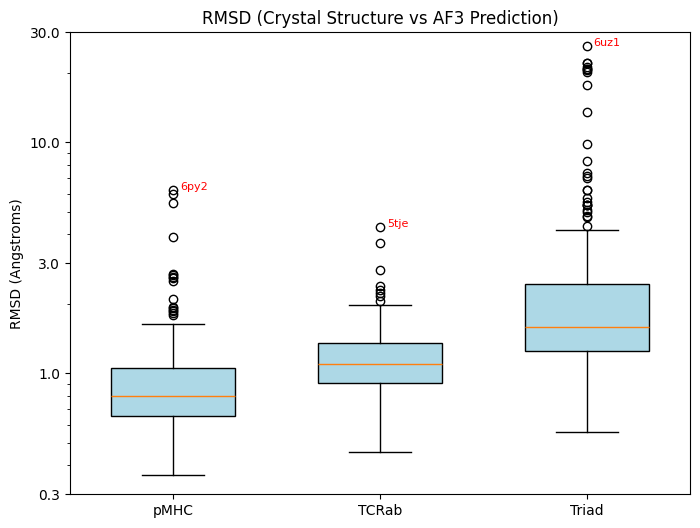

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

# Assuming rmsd_df is your Polars DataFrame:
# Filter and select the required columns
df_pl = rmsd_df.filter(pl.col("rmsd_triad").is_not_null()).select(
    ["pdb", "rmsd_triad", "rmsd_tcr", "rmsd_pmhc"]
)

# Convert the Polars DataFrame to a Pandas DataFrame for easier plotting with matplotlib
df = df_pl.to_pandas()

# Define the RMSD columns and corresponding labels for the x-axis
cols = [("rmsd_pmhc", "pMHC"), ("rmsd_tcr", "TCRab"), ("rmsd_triad", "Triad")]
data = [df[col].dropna() for col, _ in cols]
labels = [label for _, label in cols]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))
# Draw boxplots; each box is drawn at x positions 1, 2, 3
boxprops = dict(facecolor="lightblue")
bp = ax.boxplot(
    data,
    positions=[1, 2, 3],
    widths=0.6,
    patch_artist=True,
    showfliers=True,
    boxprops=boxprops,
)

# Set logarithmic scale for y-axis with specified limits and ticks
ax.set_yscale("log")
ax.set_ylim(0.3, 30)
ax.set_yticks([0.3, 1, 3, 10, 30])
ax.get_yaxis().set_major_formatter(
    plt.ScalarFormatter()
)  # Ensure tick labels are formatted as scalar values

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(labels)
ax.set_ylabel("RMSD (Angstroms)")
ax.set_title("RMSD (Crystal Structure vs AF3 Prediction)")

# For each column, compute the quartiles, IQR, and fences to identify outliers.
# Then annotate only the maximum (very highest) outlier if it exists.
for i, (col, label) in enumerate(cols):
    # Drop any NaN values from the series
    values = df[col].dropna()
    # Compute the 25th and 75th percentiles and IQR
    q1, q3 = np.percentile(values, [25, 75])
    iqr = q3 - q1
    upper_fence = q3 + 1.5 * iqr

    # Identify outliers above the upper fence only
    outliers = values[values > upper_fence]
    if not outliers.empty:
        max_outlier = outliers.max()
        # Find all indices with this maximum outlier value (in case of ties)
        max_indices = outliers[outliers == max_outlier].index
        for idx in max_indices:
            pdb_id = df.loc[idx, "pdb"]
            ax.annotate(
                str(pdb_id),
                xy=(i + 1, max_outlier),
                xytext=(5, 0),
                textcoords="offset points",
                fontsize=8,
                color="red",
            )

plt.show()